In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump
import logging
import json
import seaborn as sns

In [31]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [32]:
# Load the CSV file into a pandas DataFrame
try:
    df = pd.read_csv("datafiles/property_tag.csv")
except FileNotFoundError as e:
    logger.error("File not found: %s", e)
    raise
except pd.errors.EmptyDataError as e:
    logger.error("File is empty: %s", e)
    raise

In [33]:
print(df.columns)

Index(['system_ind', 'tag', 'num_vertices', 'iso_q', 'fractal', 'eri',
       'convexity', 'area_in_me', 'corners', 'average_distance',
       'neighbors_within_50m', 'first_neighbor', 'distance_to_nearest_road',
       'centroid_elevation', 'orientation', 'street_alignment', 'ccd_means',
       'ccd_stdev', 'cwa', 'elongation', 'squ_comp', 'squareness', 'perimeter',
       'average_alignment', 'first_neighbor_alignment'],
      dtype='object')


In [34]:
df = df.dropna()

In [35]:
for column in df.columns:
    print(f"Column {column} has {df[column].isna().sum()} NaN values")

Column system_ind has 0 NaN values
Column tag has 0 NaN values
Column num_vertices has 0 NaN values
Column iso_q has 0 NaN values
Column fractal has 0 NaN values
Column eri has 0 NaN values
Column convexity has 0 NaN values
Column area_in_me has 0 NaN values
Column corners has 0 NaN values
Column average_distance has 0 NaN values
Column neighbors_within_50m has 0 NaN values
Column first_neighbor has 0 NaN values
Column distance_to_nearest_road has 0 NaN values
Column centroid_elevation has 0 NaN values
Column orientation has 0 NaN values
Column street_alignment has 0 NaN values
Column ccd_means has 0 NaN values
Column ccd_stdev has 0 NaN values
Column cwa has 0 NaN values
Column elongation has 0 NaN values
Column squ_comp has 0 NaN values
Column squareness has 0 NaN values
Column perimeter has 0 NaN values
Column average_alignment has 0 NaN values
Column first_neighbor_alignment has 0 NaN values


In [22]:
scaler = StandardScaler()

In [23]:
# Define the features (independent variables) and the target (dependent variable)
X = df[
    [
        "num_vertices",
        "iso_q",
        "fractal",
        "eri",
        "convexity",
        "area_in_me",
        "corners",
        "average_distance",
        "neighbors_within_50m",
        "first_neighbor",
        "distance_to_nearest_road",
        "centroid_elevation",
        "orientation",
        "street_alignment",
        "ccd_means",
        "ccd_stdev",
        "cwa",
        "elongation",
        "squ_comp",
        "squareness",
        "perimeter",
        "average_alignment",
        "first_neighbor_alignment",
    ]
]

y = df["tag"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
# Create a Support Vector Machine classifier
clf = SVC(kernel='linear', random_state=42)

In [39]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", verbose=3, n_jobs=-1)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best estimator (model) from the grid search
best_clf = grid_search.best_estimator_

logger.info("Best hyperparameters according to grid search: %s", grid_search.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


INFO:__main__:Best hyperparameters according to grid search: {'C': 0.1, 'gamma': 1}


In [40]:
# Evaluate feature importance using RFE with cross-validation
def evaluate_rfe(n_features):
    rfe = RFE(estimator=best_clf, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    X_train_rfe = rfe.transform(X_train)
    scores = cross_val_score(best_clf, X_train_rfe, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
    return scores.mean()

# Evaluate performance for different numbers of features
num_features = list(range(1, X.shape[1] + 1))
scores = [evaluate_rfe(n) for n in num_features]

# Find the optimal number of features
optimal_num_features = num_features[np.argmax(scores)]
logger.info(f"Optimal number of features: {optimal_num_features}")
logger.info(f"Best cross-validation accuracy: {max(scores)}")

INFO:__main__:Optimal number of features: 17
INFO:__main__:Best cross-validation accuracy: 0.6700500542546116


In [41]:
# Fit the model with the optimal number of features
rfe = RFE(estimator=best_clf, n_features_to_select=optimal_num_features)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Refit the best model on the reduced feature set
best_clf.fit(X_train_rfe, y_train)
y_pred = best_clf.predict(X_test_rfe)

# Calculate the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
logger.info("Best model accuracy: %.2f%%", accuracy * 100)

INFO:__main__:Best model accuracy: 62.50%


In [42]:
# Cross-validation scores
cv_scores = cross_val_score(best_clf, X_train_rfe, y_train, cv=5)
logger.info("Cross-validation scores: %s", cv_scores)
logger.info("Mean cross-validation score: %.2f%%", cv_scores.mean() * 100)

# Per-class evaluation
class_report = classification_report(y_test, y_pred, target_names=best_clf.classes_.astype(str), zero_division=1)
logger.info("Classification Report:\n%s", class_report)


INFO:__main__:Cross-validation scores: [0.68411215 0.68224299 0.68037383 0.65543071 0.64981273]
INFO:__main__:Mean cross-validation score: 67.04%
INFO:__main__:Classification Report:
              precision    recall  f1-score   support

      Tier 1       1.00      0.00      0.00        17
      Tier 2       0.67      0.41      0.50       143
      Tier 3       0.61      0.89      0.73       199
      Tier 4       0.62      0.53      0.57       113

    accuracy                           0.62       472
   macro avg       0.73      0.46      0.45       472
weighted avg       0.65      0.62      0.60       472



INFO:__main__:Confusion Matrix:
[[  0  13   3   1]
 [  0  58  63  22]
 [  0   9 177  13]
 [  0   7  46  60]]


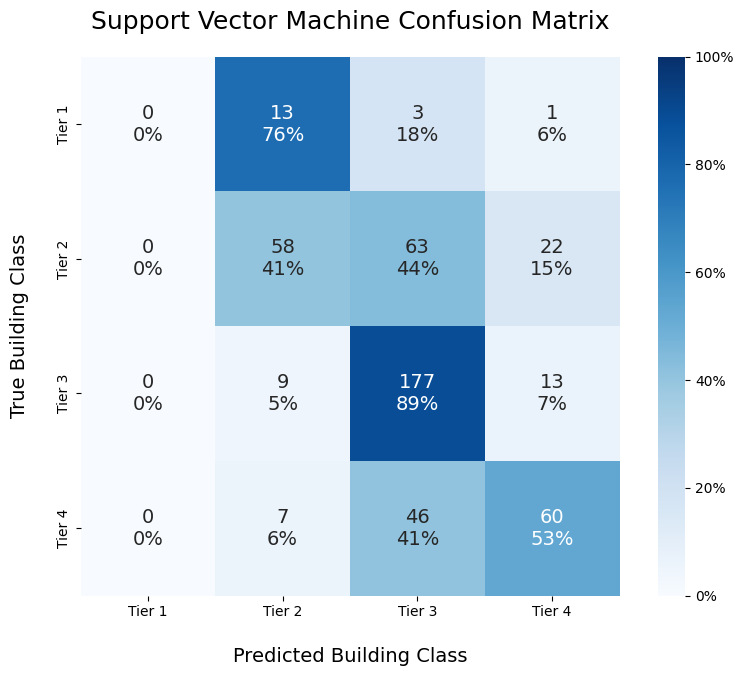

In [43]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_clf.classes_)
logger.info("Confusion Matrix:\n%s", cm)

# Calculate row-wise percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plotting the confusion matrix using seaborn
cm_df = pd.DataFrame(cm, index=best_clf.classes_, columns=best_clf.classes_)
cm_percentage_df = pd.DataFrame(cm_percentage, index=best_clf.classes_, columns=best_clf.classes_)

plt.figure(figsize=(10, 7))

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.0f}%".format(value) for value in cm_percentage.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(cm.shape)

ax = sns.heatmap(cm_percentage_df, annot=labels, fmt='', cmap='Blues', square=True, annot_kws={"size": 14}, vmin=0, vmax=100)

# Customize the title and axis labels with padding and increased font size
ax.set_title("Support Vector Machine Confusion Matrix", pad=20, fontsize=18)
ax.set_xlabel("Predicted Building Class", labelpad=20, fontsize=14)
ax.set_ylabel("True Building Class", labelpad=20, fontsize=14)

# Customize the color bar to show percentages
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))

plt.show()


In [44]:
# Since SVMs don't provide feature importances directly, we'll use the RFE ranking instead
rfe_ranking = rfe.ranking_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'RFE Ranking': rfe_ranking
})

# Sort the DataFrame by RFE ranking
feature_importance_df.sort_values(by='RFE Ranking', inplace=True)

# Print the feature importances
print(feature_importance_df)

                     Feature  RFE Ranking
0               num_vertices            1
20                 perimeter            1
16                       cwa            1
15                 ccd_stdev            1
14                 ccd_means            1
13          street_alignment            1
12               orientation            1
21         average_alignment            1
10  distance_to_nearest_road            1
11        centroid_elevation            1
8       neighbors_within_50m            1
7           average_distance            1
5                 area_in_me            1
4                  convexity            1
3                        eri            1
2                    fractal            1
9             first_neighbor            1
19                squareness            2
6                    corners            3
22  first_neighbor_alignment            4
17                elongation            5
18                  squ_comp            6
1                      iso_q      

In [45]:
# Export the model to a file
dump(best_clf, 'datafiles/results/Support Vector Machine/svm_model.joblib')

# Export predictions to a file
dump(y_pred, 'datafiles/results/Support Vector Machine/svm_predictions.joblib')

# Export tests to a file
dump(y_test, 'datafiles/results/Support Vector Machine/svm_tests.joblib')

# Export training results
results = {
    'best_params': grid_search.best_params_,
    'accuracy': accuracy,
    'feature_importances': feature_importance_df.to_dict()
}
with open('datafiles/results/Support Vector Machine/svm_model_results.json', 'w') as f:
    json.dump(results, f)